# Importing packages

In [246]:
from utils.model_summary_functions import feature_importance, metrics, summary_plot,multivariate_importance

In [247]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold, StratifiedShuffleSplit, TimeSeriesSplit, RepeatedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor,GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest, f_regression, chi2
from sklearn.linear_model import LassoLarsCV,LassoCV, Lasso
from sklearn.decomposition import PCA

from yellowbrick.model_selection import FeatureImportances
from yellowbrick.regressor import residuals_plot
from yellowbrick.regressor import prediction_error
from yellowbrick.model_selection import learning_curve
from yellowbrick.model_selection import feature_importances

import tensorflow as tf

In [248]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [249]:
import warnings  # Ignore alert messages
warnings.filterwarnings('ignore')

In [250]:
plt.style.use('default')

plt.rcParams.update({
    'font.size': 16,
    'axes.linewidth': 2,
    'axes.titlesize': 20,
    'axes.edgecolor': 'black',
    'axes.labelsize': 20,
    'axes.grid': True,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'figure.figsize': (15, 6),
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'font.family': 'Arial',
    'legend.fontsize': 13,
    'legend.framealpha': 1,
    'legend.edgecolor': 'black',
    'legend.shadow': False,
    'legend.fancybox': True,
    'legend.frameon': True,
})

# Objective

- Visualize the model results in the frequency domain to confirm if the output has the same wavelength range as the simulation irregularities (wavelength of 3m and 25m)
- See if filtering the model output will produce a better result
- Use model explainability techniques such as SHAP values to explain how the model does the prediction

# Importing dataset after EDA

In [251]:
df = pd.read_csv("Processed_data/FRA3-FRA6_cleaned_feature_engineered.csv.zip")
df

,SS_Z_TR,SS_Z_LL,SS_Z_TL,SS_Z_LR,TA_X,TA_Z,UA_Z_LR,SuspTravel_L,SuspTravel_R,Pitch_Acc,...,TA_X_RMA,TA_X_MA,TA_X_RMS,TA_Z_mean,SuspTravel_mean,SuspTravel_skew,Pitch_Susp_L_mean,Bounce_Susp_mean,FrontRoll_Susp_skew,Irr_Z_RR
0,-0.034100,0.030900,0.021800,-0.0218,-0.000116,-0.000749,-0.001817,0.030900,-0.034100,-0.000459,...,0.008054,0.000065,0.000457,-0.000293,0.004538,-1.143003,0.000911,0.001606,0.941525,-0.0712
1,-0.035600,0.031600,0.022800,-0.0228,-0.000139,-0.000749,-0.001812,0.031600,-0.035600,-0.000542,...,0.008238,0.000068,0.000457,-0.000307,0.003883,-1.156428,0.000941,0.001485,0.893110,-0.0753
2,-0.036700,0.032000,0.023700,-0.0239,-0.000162,-0.000727,-0.001605,0.032000,-0.036700,-0.000613,...,0.008436,0.000071,0.000458,-0.000320,0.003208,-1.139831,0.000970,0.001362,0.843661,-0.0791
3,-0.037000,0.031400,0.024400,-0.0248,-0.000182,-0.000650,-0.000912,0.031400,-0.037000,-0.000654,...,0.008647,0.000075,0.000459,-0.000332,0.002527,-1.100159,0.000993,0.001242,0.787577,-0.0827
4,-0.037300,0.030900,0.025100,-0.0257,-0.000202,-0.000574,-0.000219,0.030900,-0.037300,-0.000695,...,0.008870,0.000079,0.000459,-0.000342,0.001840,-1.048016,0.001013,0.001125,0.728316,-0.0858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68096,-0.111903,-0.231038,0.133286,0.0503,0.001834,0.000079,0.004336,-0.231038,-0.111903,-0.003638,...,0.053665,0.002880,0.004202,-0.009225,-0.722654,-0.835219,-0.063069,-0.147773,-0.773285,0.0486
68097,-0.113222,-0.225703,0.140285,0.0422,0.001846,-0.000082,0.003567,-0.225703,-0.113222,-0.003363,...,0.053726,0.002887,0.004204,-0.008988,-0.693827,-0.847119,-0.063281,-0.143451,-0.788629,0.0511
68098,-0.114092,-0.220937,0.148758,0.0347,0.001823,-0.000321,0.002644,-0.220937,-0.114092,-0.003317,...,0.053553,0.002868,0.004196,-0.008838,-0.666117,-0.856692,-0.063529,-0.139384,-0.803025,0.0535
68099,-0.114961,-0.216170,0.157232,0.0272,0.001800,-0.000559,0.001721,-0.216170,-0.114961,-0.003272,...,0.053190,0.002829,0.004170,-0.008807,-0.639543,-0.864403,-0.063821,-0.135586,-0.816822,0.0558


In [252]:
df_aux = df.copy()

In [335]:
def create_scaled_dataset(X,y,shuffle=False):
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=0,shuffle=shuffle) #Shuffle was set to false to allow correct plotting of the PSD

    std_scaler = StandardScaler()
    X_scaled_train = pd.DataFrame(std_scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
    X_scaled_test = pd.DataFrame(std_scaler.transform(X_test),columns=X_train.columns,index=X_test.index)
    return X_scaled_train,X_scaled_test, y_train,y_test

In [336]:
y = df_aux['Irr_Z_RR']
X = df_aux.drop(['Irr_Z_RR'],axis=1)

X_scaled_train2,X_scaled_test2,y_train2,y_test2 = create_scaled_dataset(X,y)

In [337]:
# y_train2 = pd.DataFrame(y_train2)
# y_test2 = pd.DataFrame(y_test2) 

In [338]:
# X_scaled_train2.reset_index(inplace=True,drop=True)
# X_scaled_test2.reset_index(inplace=True,drop=True)
# y_train2.reset_index(inplace=True,drop=True)
# y_test2.reset_index(inplace=True,drop=True)

# Loading models

In [339]:
def load_model(name, path):
    import pickle
    filename = path + '/' + name
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model

In [340]:
#path = 'models/ml_models'
#knn = load_model('KNN_Regressor.sav',path=path)

knn = tf.keras.models.load_model("models/NN/Vanilla_NN_re")

In [341]:
yhat = pd.DataFrame(knn.predict(X_scaled_test2))
#yhat = knn.predict(X_scaled_test2)
yhat=yhat[0]
yhat

0       -6.127227
1       -5.916914
2       -5.852606
3       -5.799404
4       -5.603551
           ...   
20426   -0.245225
20427   -0.249104
20428   -0.267459
20429   -0.277183
20430   -0.288099
Name: 0, Length: 20431, dtype: float32

In [342]:
metrics(y_test2,yhat)

MSE:0.3905498585896212 
MAE:0.4693145224005278 
R2:0.987031660699354


# Checking irregularity spectrum

## Calculating the PSD

In [343]:
from utils.FRA_class import FRA_irregularities

from scipy import signal
from scipy.signal import welch, butter, filtfilt
import plotly.graph_objects as go

In [344]:
# yhat = knn.predict(X_scaled_test)
# yhat

In [345]:
def Welch_PSD(signal, fs, window_size_frac=0.2, overlap_frac=0.5):

    #fs = sampling frequency - samples in 1 meter

    segment_size = np.int32(window_size_frac*len(signal))
    # round up to next highest power of 2 - used for zero padding
    fft_size = 2 ** (int(np.log2(segment_size)) + 1)

    overlap_size = overlap_frac*segment_size

    f, welch_coef = welch(x=signal,
                          fs=fs,
                          nperseg=segment_size,
                          #noverlap=segment_size+1,
                          nfft=fft_size,
                          return_onesided=True,
                          scaling='density',
                          detrend='constant',
                          window='hann',
                          average='mean')

    return f, welch_coef

In [346]:
#y_test2 = y_test2.to_numpy()

In [347]:
# PSD using Welch's method
f_target, welch_coef_target = Welch_PSD(1e-3*y_test2, fs=1/0.108)
f_predicted, welch_coef_predicted = Welch_PSD(1e-3*yhat, fs=1/0.108)

## Plotting the PSD

In [348]:
# Class responsible for creating the FRA irregularities (FRA_class.py)
FRA = FRA_irregularities()
# wavelength domain, spatial angular frequency domain, vertical FRA, lateral FRA
wave, omega, vert, lat = FRA._create_PSD(class_list=[6, 5, 4, 3])

Classes [6, 5, 4, 3] were created


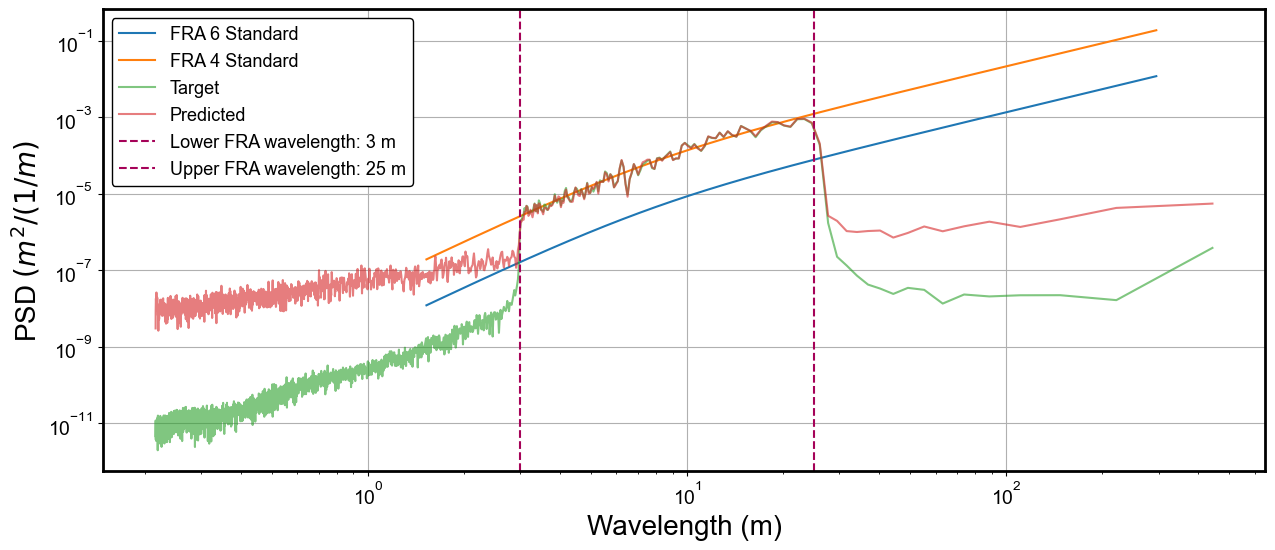

In [349]:
# Plotting the FRA standard with the target variable and generated irregularities

plt.plot(wave, vert[0], label='FRA 6 Standard')
#plt.plot(wave,vert[1],label='FRA 5 Standard')
plt.plot(wave,vert[2],label='FRA 4 Standard')
#plt.plot(wave, vert[3], label='FRA 3 Standard')


plt.plot(1/f_target, welch_coef_target, label='Target',alpha=0.6)
plt.plot(1/f_predicted, welch_coef_predicted, label='Predicted',alpha=0.6)

plt.xlabel('Wavelength (m)')
plt.ylabel('PSD $(m^2/(1/m)$')
plt.xscale('log')
plt.yscale('log')


plt.axvline(3, label='Lower FRA wavelength: {} m'.format(3),color='m', linestyle='--')
plt.axvline(25, label='Upper FRA wavelength: {} m'.format(25), color='m', linestyle='--')

#plt.xlim([1,400])
#plt.ylim([10e-11,10e-1])
plt.legend()

In [350]:
# # Plotting the FRA standard with the target variable and generated irregularities

# #plt.plot(wave, vert[0], label='FRA 6 Standard')
# #plt.plot(wave,vert[1],label='FRA 5 Standard')
# plt.plot(wave,vert[2],label='FRA 4 Standard')
# #plt.plot(wave, vert[3], label='FRA 3 Standard')


# plt.plot(1/f_target, welch_coef_target, label='Target', alpha=0.6)
# plt.plot(1/f_predicted, welch_coef_predicted, label='Predicted', alpha=0.6)

# plt.xlabel('Wavelength (m)')
# plt.ylabel('PSD $(m^2/(1/m)$')
# plt.xscale('log')
# plt.yscale('log')


# plt.axvline(3, label='Lower FRA wavelength: {} m'.format(3),
#             color='m', linestyle='--')
# plt.axvline(25, label='Lower FRA wavelength: {} m'.format(
#     25), color='m', linestyle='--')

# #plt.xlim([2,26])
# #plt.ylim([10e-8, 10e-2])
# plt.xlim([10, 15])
# plt.ylim([10e-5, 10e-4])

# plt.legend()

In [351]:
# plt.plot(1/f_target, welch_coef_target, label='Target')
# plt.plot(1/f_predicted, welch_coef_predicted, label='Predicted')
# plt.xlim([2, 30])
# plt.axvline(3, label='Lower FRA wavelength: {} m'.format(3),color='m', linestyle='--')
# plt.axvline(25, label='Lower FRA wavelength: {} m'.format(25),color='m', linestyle='--')
# plt.xlabel('Wavelength (m)')
# plt.ylabel('Amplitude (m)')
# plt.legend()

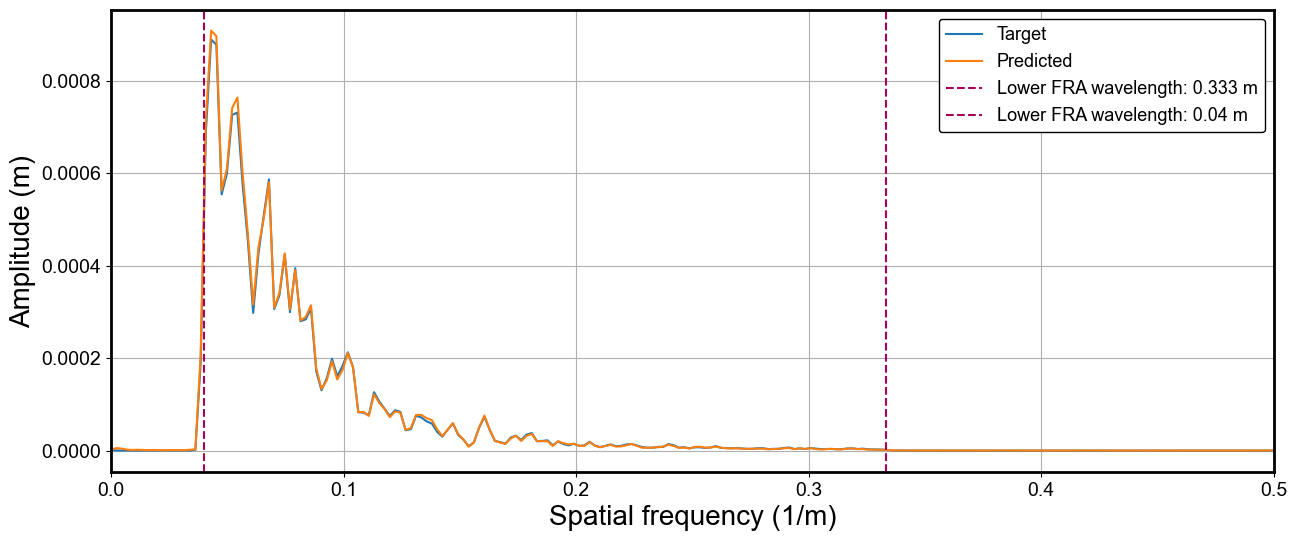

In [352]:
plt.plot(f_target, welch_coef_target, label='Target')
plt.plot(f_predicted, welch_coef_predicted, label='Predicted')
plt.xlim([0, 0.5])
plt.axvline(1/3, label='Lower FRA wavelength: {} m'.format(0.333),color='m', linestyle='--')
plt.axvline(1/25, label='Lower FRA wavelength: {} m'.format(1/25),color='m', linestyle='--')
plt.xlabel('Spatial frequency (1/m)')
plt.ylabel('Amplitude (m)')
plt.legend()

# Filtering out high spatial frequencies

In [353]:
sampling_rate = 1/0.108 # samples/m
sampling_rate

9.25925925925926

In [354]:
def butter_lowpass_filter(data, cutoff, fs, order, nyq=5):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y


filtered_signal = butter_lowpass_filter(data=yhat, cutoff=0.40, fs=sampling_rate, order=8)
f_filtered, welch_coef_filtered = Welch_PSD(1e-3*filtered_signal, fs=sampling_rate)

In [355]:
# plt.plot(f_predicted,welch_coef_predicted, label='Unfiltered')
# plt.plot(f_filtered, welch_coef_filtered, label='Filtered')
# plt.legend()
# plt.xlim([0,0.4])

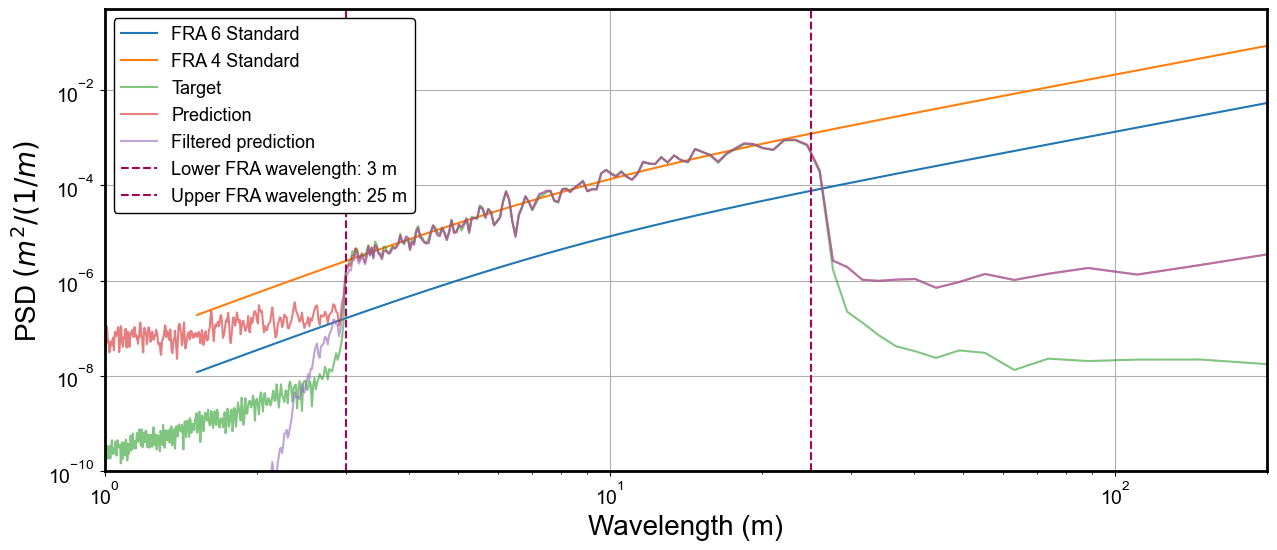

In [356]:
# Plotting the FRA standard with the target variable and generated irregularities

plt.plot(wave, vert[0], label='FRA 6 Standard')
#plt.plot(wave,vert[1],label='FRA 5 Standard')
plt.plot(wave, vert[2], label='FRA 4 Standard')
#plt.plot(wave, vert[3], label='FRA 3 Standard')


plt.plot(1/f_target, welch_coef_target, label='Target', alpha=0.6)
plt.plot(1/f_predicted, welch_coef_predicted, label='Prediction', alpha=0.6)
plt.plot(1/f_filtered, welch_coef_filtered,label='Filtered prediction', alpha=0.6)

plt.xlabel('Wavelength (m)')
plt.ylabel('PSD $(m^2/(1/m)$')
plt.xscale('log')
plt.yscale('log')


plt.axvline(3, label='Lower FRA wavelength: {} m'.format(3),color='m', linestyle='--')
plt.axvline(25, label='Upper FRA wavelength: {} m'.format(25), color='m', linestyle='--')

plt.xlim([1,200])
plt.ylim([1e-10,5e-1])
plt.legend()

# Model metrics

In [357]:
#X_scaled_train2,X_scaled_test2,y_train2,y_test2 = create_scaled_dataset(X,y,shuffle=False)

In [358]:
yhat = pd.DataFrame(knn.predict(X_scaled_test2))
yhat=yhat[0]

In [359]:
# No filter
metrics(yhat,y_test2)

MSE:0.3905498585896212 
MAE:0.4693145224005278 
R2:0.9872300630845505


In [360]:
# 4th order butterworth filter with cutoff frequency of 0.4 [1/m]. The wavelength limits are 0.04 and 0.333
metrics(filtered_signal, y_test2)

MSE:0.26913252234707663 
MAE:0.40781773027453505 
R2:0.9911575518874737


Text(0, 0.5, 'Vertical irregularity (mm)')

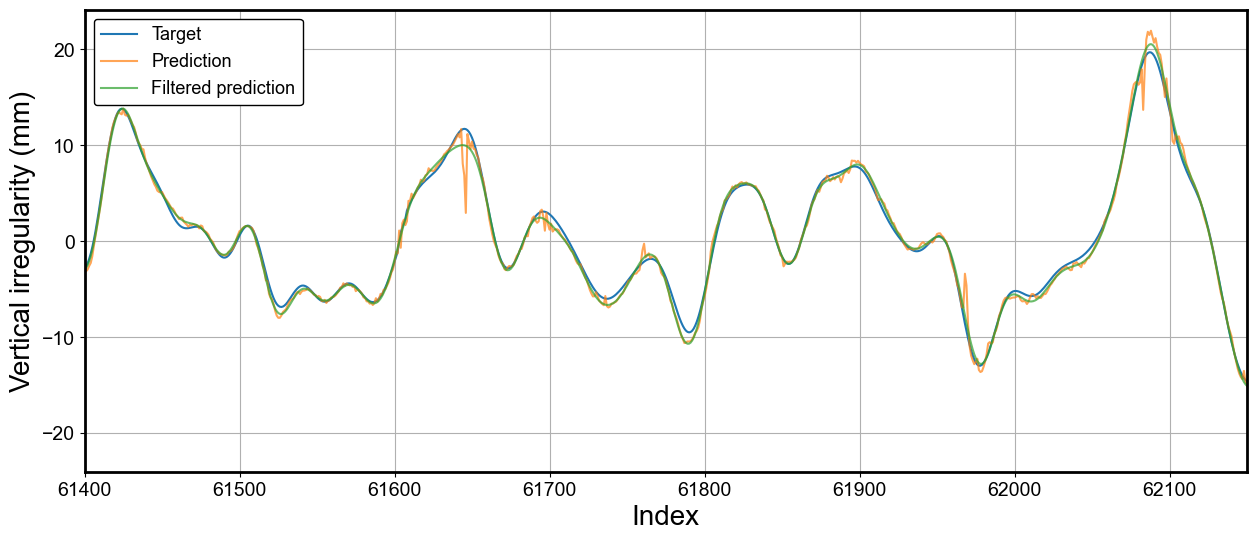

In [361]:
plt.plot(y_test2.index, y_test2, label='Target')
plt.plot(y_test2.index,yhat, label='Prediction',alpha=0.7)
plt.plot(y_test2.index,filtered_signal, label='Filtered prediction',alpha=0.7)
plt.legend()
plt.xlim([61400,62150])

plt.xlabel('Index')
plt.ylabel('Vertical irregularity (mm)')